# Metrics Visualization for Different Clipping Norms

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from analysis_util import load_and_extract_metrics

In [53]:
# Set Seaborn style and context
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 10))

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

## Data Preparation

In [54]:
paths = {
    0.1: 'SimulationOutputs/Quantitative/clipping_norm_0.1/metrics.json',
    0.5: 'SimulationOutputs/Quantitative/clipping_norm_0.5/metrics.json',
    1.0: 'SimulationOutputs/Quantitative/clipping_norm_1.0/metrics.json',
    2.0: 'SimulationOutputs/Quantitative/clipping_norm_2.0/metrics.json',
    5.0: 'SimulationOutputs/Quantitative/clipping_norm_5.0/metrics.json',
    10.0: 'SimulationOutputs/Quantitative/clipping_norm_10.0/metrics.json',
    15.0: 'SimulationOutputs/Quantitative/clipping_norm_15/metrics.json',
    20.0: 'SimulationOutputs/Quantitative/clipping_norm_20/metrics.json',
    25: 'SimulationOutputs/Quantitative/clipping_norm_25/metrics.json',
    50: 'SimulationOutputs/Quantitative/clipping_norm_50/metrics.json',
    100: 'SimulationOutputs/Quantitative/clipping_norm_100/metrics.json',
    float('inf'): 'SimulationOutputs/Quantitative/clipping_norm_inf/metrics.json'
}

In [55]:
# Load metrics for each clipping norm
clipping_norm_metrics = {}
for clipping_norm, path in paths.items():
    clipping_norm_metrics[clipping_norm] = load_and_extract_metrics(path)

In [56]:
# Prepare data for plotting
def prepare_metrics_dataframe(clipping_norm_metrics, metric_type):
    data = []
    for clipping_norm, metrics in clipping_norm_metrics.items():
        for round_num, accuracy in enumerate(metrics[metric_type]):
            data.append({
                'Clipping Norm': clipping_norm,
                'Round': round_num,
                'Accuracy': accuracy
            })
    return pd.DataFrame(data)

In [57]:
server_df = prepare_metrics_dataframe(clipping_norm_metrics, 'server_metrics')
client_df = prepare_metrics_dataframe(clipping_norm_metrics, 'aggregated_metrics')

client_df['Round'] = client_df['Round'] + 1 # Shift rounds by 1

best_metrics = {
    'Clipping Norm': list(clipping_norm_metrics.keys()),
    'Server Best Metrics': [metrics['best_server_metric'] for metrics in clipping_norm_metrics.values()],
    'Aggregated Best Metrics': [metrics['best_aggregated_metric'] for metrics in clipping_norm_metrics.values()]
}

best_metrics_df = pd.DataFrame(best_metrics)

## First Visualization: Accuracy per Round Comparison

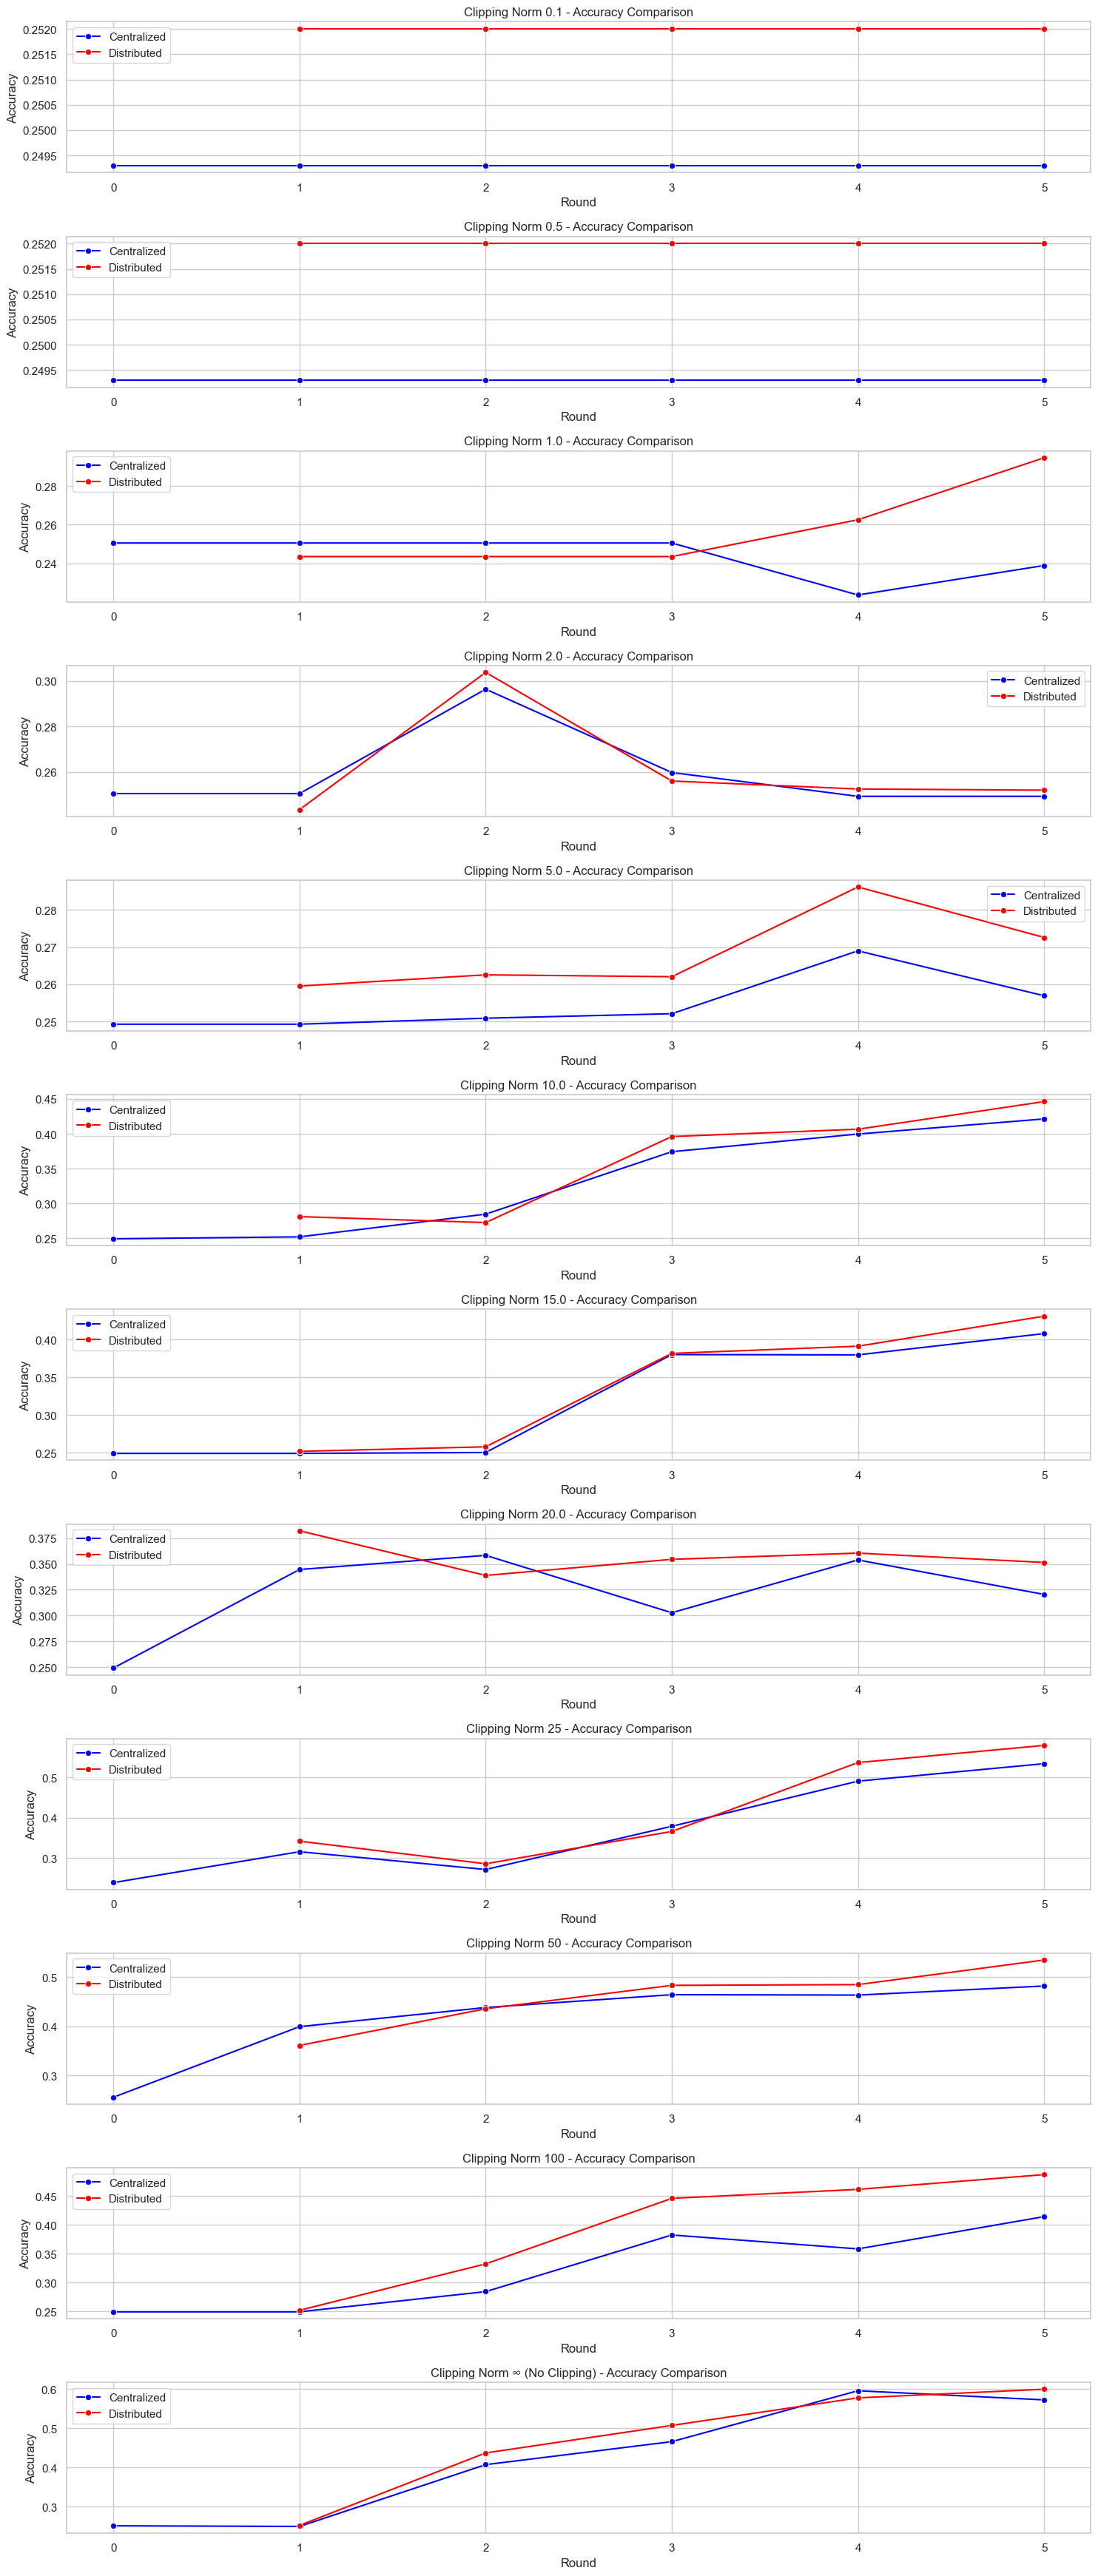

In [59]:
plt.figure(figsize=(15, 35))

for j, clipping_norm in enumerate(sorted(clipping_norm_metrics.keys())):
    plt.subplot(12, 1, j + 1)
    
    # Plot centralized accuracy
    centralized_subset = server_df[server_df['Clipping Norm'] == clipping_norm]
    sns.lineplot(data=centralized_subset, x='Round', y='Accuracy', 
                marker='o', color='blue', label='Centralized')
    
    # Plot distributed accuracy
    distributed_subset = client_df[client_df['Clipping Norm'] == clipping_norm]
    sns.lineplot(data=distributed_subset, x='Round', y='Accuracy', 
                marker='o', color='red', label='Distributed')
    
    title = f'∞ (No Clipping)' if np.isinf(clipping_norm) else f'{clipping_norm}'
    plt.title(f'Clipping Norm {title} - Accuracy Comparison')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

## Best Metrics as Function of Clipping Norm

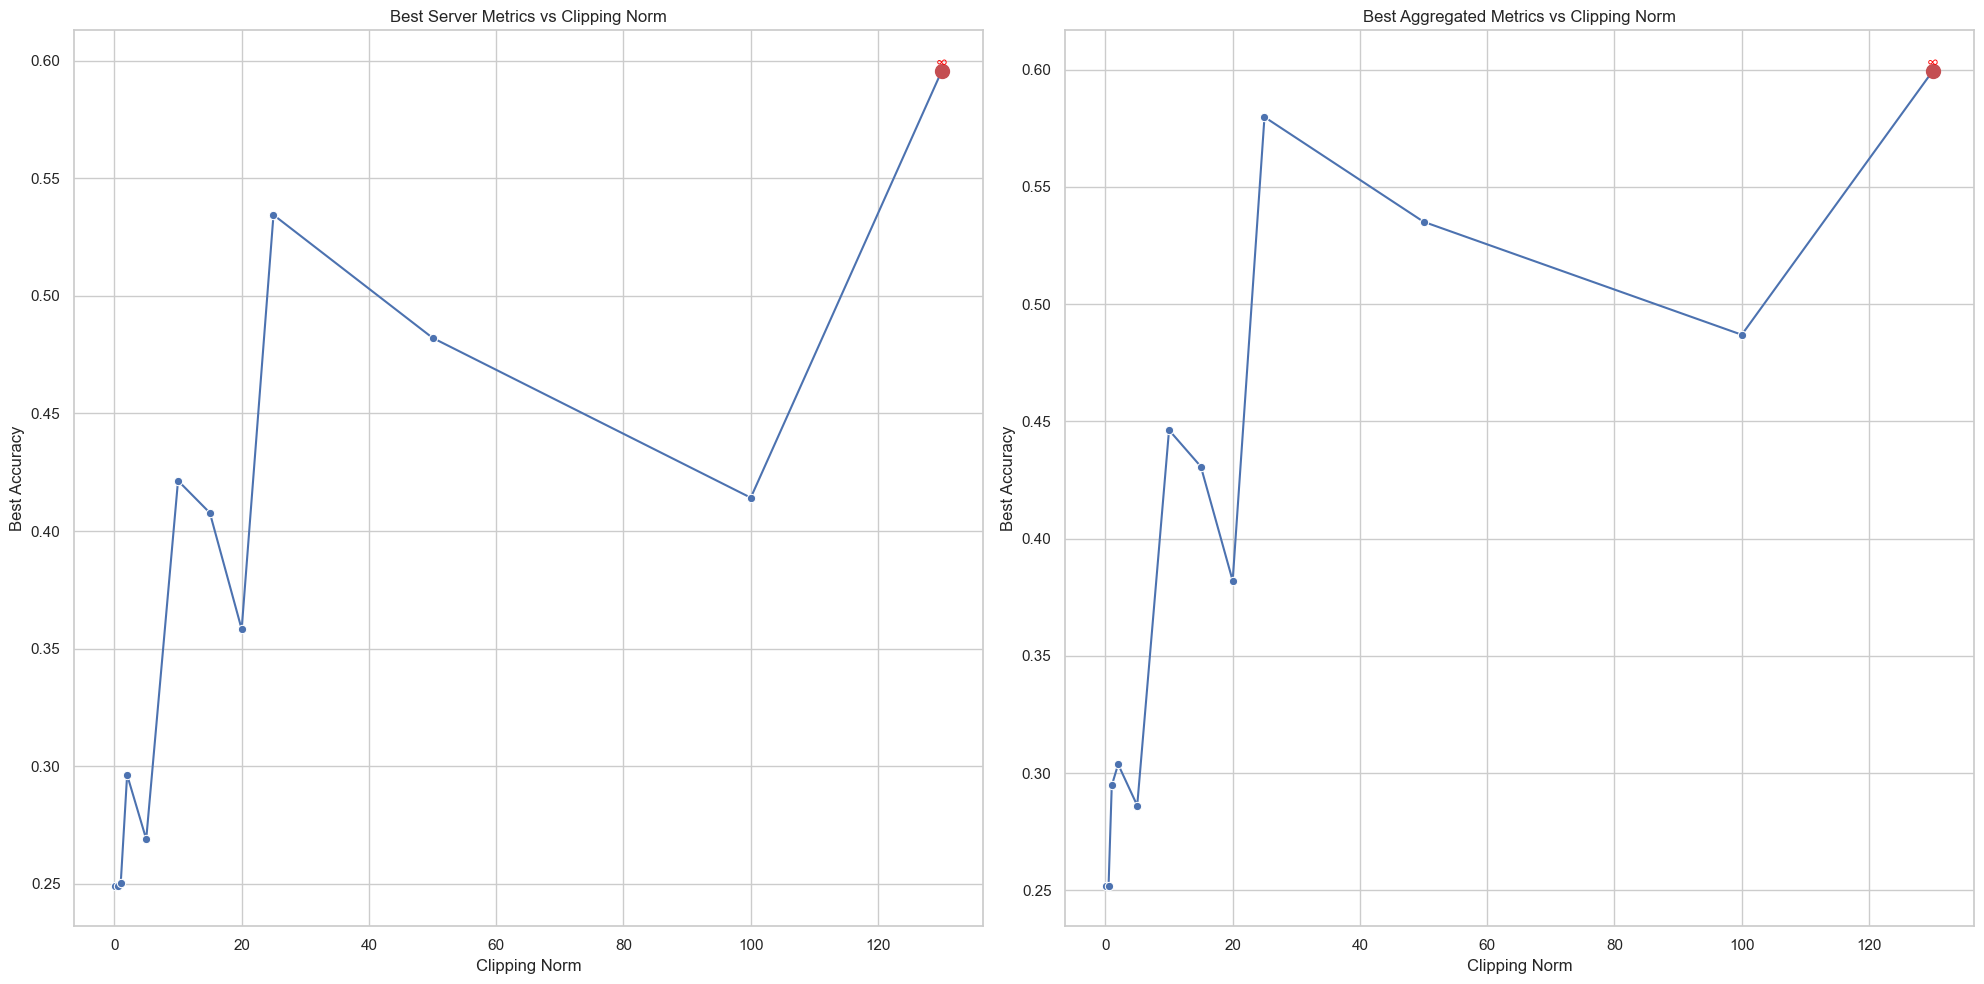

In [60]:
def plot_with_inf(df, x_col, y_col, title):
    # Create a copy of the dataframe and replace inf with 1.3 * max of finite values
    plot_df = df.copy()
    max_finite = plot_df[~np.isinf(plot_df[x_col])][x_col].max()
    plot_df.loc[np.isinf(plot_df[x_col]), x_col] = max_finite * 1.3
    
    # Plot the line with all points
    sns.lineplot(data=plot_df, x=x_col, y=y_col, marker='o')
    
    # Find the inf point and highlight it in red
    inf_point = plot_df.loc[df[x_col] == float('inf')]
    if not inf_point.empty:
        plt.plot(inf_point[x_col], inf_point[y_col], 'ro', markersize=10)
        plt.text(inf_point[x_col].iloc[0], inf_point[y_col].iloc[0], '∞', 
                color='red', ha='center', va='bottom')
    
    plt.title(title)
    plt.xlabel('Clipping Norm')
    plt.ylabel('Best Accuracy')

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plot_with_inf(best_metrics_df, 'Clipping Norm', 'Server Best Metrics', 'Best Server Metrics vs Clipping Norm')

plt.subplot(1, 2, 2)
plot_with_inf(best_metrics_df, 'Clipping Norm', 'Aggregated Best Metrics', 'Best Aggregated Metrics vs Clipping Norm')

plt.tight_layout()
plt.show()